# Machine Learning: Project 2
## Task 1

In [1]:
from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [2]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [3]:
# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(data_home= "./datasets/task1/lfw_funneled",min_faces_per_person=5, resize=0.4,download_if_missing= False)

# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:",X.shape)
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size: (331, 1850)
n_samples: 331
n_features: 1850
n_classes: 17


In [4]:
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [5]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Extracting the top 150 eigenfaces from 248 faces
done in 0.147s
Projecting the input data on the eigenfaces orthonormal basis
done in 0.005s


In [6]:
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:626: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


done in 5.724s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

# print(classification_report.__doc__)

print(classification_report(y_test, y_pred, labels=range(n_classes), target_names=target_names))
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
done in 0.006s
                         precision    recall  f1-score   support

          Arminio Fraga       1.00      0.50      0.67         2
             Bob Graham       0.00      0.00      0.00         0
      Colin Montgomerie       0.00      0.00      0.00         1
         George HW Bush       1.00      0.33      0.50         3
      Gerhard Schroeder       0.72      0.96      0.83        27
Gloria Macapagal Arroyo       0.83      1.00      0.91        15
           Gordon Brown       1.00      1.00      1.00         4
            Igor Ivanov       0.43      0.60      0.50         5
             JK Rowling       1.00      1.00      1.00         1
            John Howard       0.25      0.33      0.29         3
            John Manley       0.00      0.00      0.00         3
                Li Peng       0.00      0.00      0.00         1
     Michael Schumacher       0.50      0.75      0.60         4
            Paul ONeill       1.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [15]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

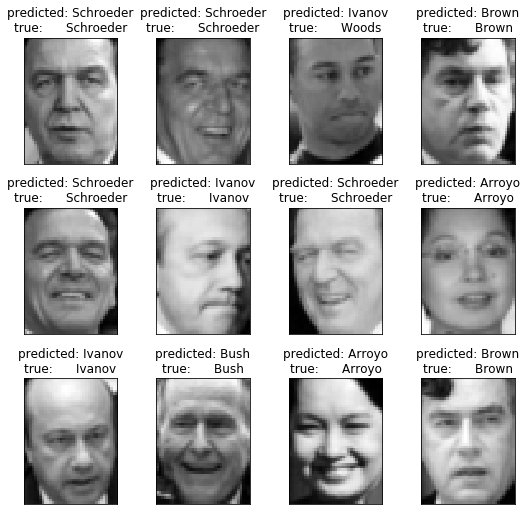

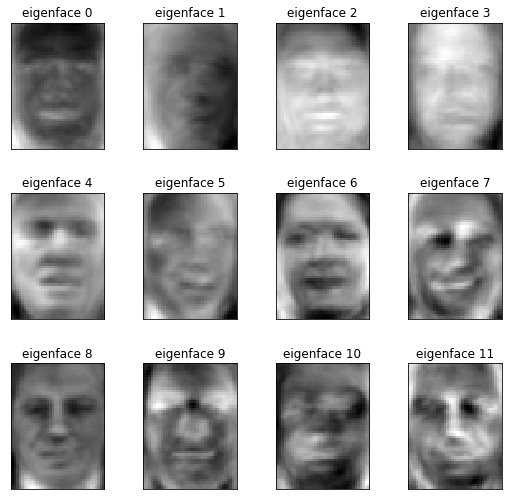

In [16]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()